In [5]:
import os
import glob
import pandas as pd
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import pydicom

In [16]:
# read data
INPUT_DIR = 'rsna-2024-lumbar-spine-degenerative-classification'

train = pl.read_csv(f'{INPUT_DIR}/train.csv')
print(train.head())
train_label = pl.read_csv(f'{INPUT_DIR}/train_label_coordinates.csv')
print(train_label[1])
train_desc = pl.read_csv(f'{INPUT_DIR}/train_series_descriptions.csv')
print(train_desc)

shape: (5, 26)
┌──────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ study_id ┆ spinal_ca ┆ spinal_ca ┆ spinal_ca ┆ … ┆ right_sub ┆ right_sub ┆ right_sub ┆ right_sub │
│ ---      ┆ nal_steno ┆ nal_steno ┆ nal_steno ┆   ┆ articular ┆ articular ┆ articular ┆ articular │
│ i64      ┆ sis_l1_l2 ┆ sis_l2_l3 ┆ sis_l3_l4 ┆   ┆ _stenosis ┆ _stenosis ┆ _stenosis ┆ _stenosis │
│          ┆ ---       ┆ ---       ┆ ---       ┆   ┆ _l2…      ┆ _l3…      ┆ _l4…      ┆ _l5…      │
│          ┆ str       ┆ str       ┆ str       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│          ┆           ┆           ┆           ┆   ┆ str       ┆ str       ┆ str       ┆ str       │
╞══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 4003253  ┆ Normal/Mi ┆ Normal/Mi ┆ Normal/Mi ┆ … ┆ Normal/Mi ┆ Normal/Mi ┆ Normal/Mi ┆ Normal/Mi │
│          ┆ ld        ┆ ld        ┆ ld        ┆   ┆ ld        ┆ ld        ┆

shape: (25, 3)
┌────────────┬────────────┬──────────┐
│ column_0   ┆ column_1   ┆ column_2 │
│ ---        ┆ ---        ┆ ---      │
│ i64        ┆ i64        ┆ i64      │
╞════════════╪════════════╪══════════╡
│ 4290709089 ┆ 3274612423 ┆ 9        │
│ 4290709089 ┆ 3274612423 ┆ 9        │
│ 4290709089 ┆ 3274612423 ┆ 9        │
│ 4290709089 ┆ 3274612423 ┆ 9        │
│ 4290709089 ┆ 3274612423 ┆ 9        │
│ …          ┆ …          ┆ …        │
│ 4290709089 ┆ 4237840455 ┆ 11       │
│ 4290709089 ┆ 4237840455 ┆ 12       │
│ 4290709089 ┆ 4237840455 ┆ 12       │
│ 4290709089 ┆ 4237840455 ┆ 12       │
│ 4290709089 ┆ 4237840455 ┆ 12       │
└────────────┴────────────┴──────────┘
=====study_id:4290709089, series_id:3274612423, instance_number:9=====


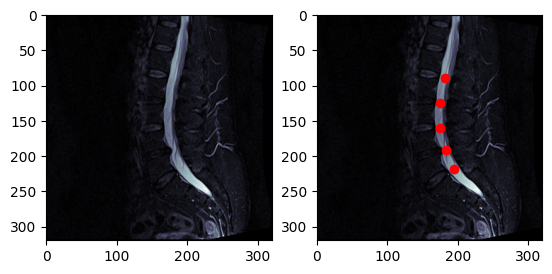

In [19]:
def graph_plot(study_id, series_id):
    train_label_combinations = pl.DataFrame()
    for row in train_label.iter_rows():
        if row[0]==study_id:
            print(pl.DataFrame(row[:3]).transpose())
            data = pl.DataFrame(row[:3]).transpose()
            train_label_combinations=pl.concat([train_label_combinations, data])
    print(train_label_combinations)
    
    #rename columns
    train_label_combinations = train_label_combinations.rename({"column_0":"study_id", "column_1":"series_id", "column_2":"instance_number"})
    #extract unique combination
    train_label_combinations = train_label_combinations.unique(subset=["study_id", "series_id", "instance_number"]).sort(["study_id", "series_id", "instance_number"])
    
    instance_number_list = train_label_combinations.filter((pl.col("study_id")==study_id) & (pl.col("series_id")==series_id)).get_column("instance_number")
    #instance_number_list

    for instance_number in instance_number_list:
        #print(instance_number)
        print(f"=====study_id:{study_id}, series_id:{series_id}, instance_number:{instance_number}=====")
        #read image
        ds = pydicom.read_file(f'{INPUT_DIR}/train_images/{study_id}/{series_id}/{instance_number}.dcm')
        #draw original image
        df_plt = train_label.filter(
            (pl.col('study_id')==study_id)
            &(pl.col('series_id')==series_id)
            &(pl.col('instance_number')==instance_number)
        )
        plt.subplot(1,2,1)
        plt.imshow(ds.pixel_array, cmap='bone')
        #plt.title(f"study_id:{study_id}, series_id:{series_id}, instance_number:{instance_number}")

        #draw original image + label
        #draw image
        df_plt = train_label.filter(
            (pl.col('study_id')==study_id)
            &(pl.col('series_id')==series_id)
            &(pl.col('instance_number')==instance_number)
        )
        plt.subplot(1,2,2)
        plt.imshow(ds.pixel_array, cmap='bone')
        #plt.title(f"study_id:{study_id}, series_id:{series_id}, instance_number:{instance_number}")
        #draw rabel
        for row in df_plt.iter_rows():
            plt.scatter(row[-2], row[-1], color='red')
        plt.show()

study_id, series_id = 4290709089, 3274612423
graph_plot(study_id, series_id)

# Visualize the pixel array

In [24]:
from PIL import Image

ds = pydicom.dcmread(f'{INPUT_DIR}/train_images/{study_id}/{series_id}/{8}.dcm')

new_image = ds.pixel_array.astype(float)

scaled_image = (np.maximum(new_image, 0) / new_image.max()) * 255.0

scaled_image = np.uint8(scaled_image)
final_image = Image.fromarray(scaled_image)
final_image.show()
